In [156]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer

from lazypredict.Supervised import LazyClassifier
import pycaret
import shap


In [157]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [158]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
subs = pd.read_csv('gender_submission.csv')

In [159]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [160]:
test_data['Cabin'].value_counts().head(50)

Cabin
B57 B59 B63 B66    3
B45                2
C89                2
C55 C57            2
A34                2
F4                 2
C6                 2
C23 C25 C27        2
C31                2
C101               2
C80                2
E34                2
C78                2
C116               2
C22 C26            1
C32                1
B69                1
F E46              1
B26                1
D                  1
D21                1
C86                1
D37                1
C85                1
B78                1
C106               1
F E57              1
C39                1
D38                1
D40                1
C7                 1
B41                1
D28                1
B24                1
B52 B54 B56        1
F2                 1
E39 E41            1
E50                1
E60                1
D10 D12            1
B51 B53 B55        1
A18                1
F33                1
B58 B60            1
B11                1
A11                1
B36                1
A21    

In [161]:
# Perform the join
test_data = test_data.merge(subs, on='PassengerId', how='left')

In [162]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [163]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [164]:
def preprocess_data(df):
    # Step 1: Extract Deck from Cabin
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    
    def substrings_in_string(s, substrings):
        if pd.isna(s):
            return 'Unknown'
        for substring in substrings:
            if substring in s:
                return substring
        return 'Unknown'

    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode().iloc[0], inplace = True)
    # Continuous Variable

    df['Deck'] = df['Cabin'].apply(lambda x: substrings_in_string(x, cabin_list))
    df['Family_Size'] = df['SibSp'] + df['Parch'] + 1
    # Step 5: Map 'Sex' to binary values
    df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
    df['IsAlone'] = 1 #initialize to yes/1 is alone
    df['IsAlone'].loc[df['Family_Size'] > 1] = 0
    df['Title']=0
    df['Title']=df.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    df['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col',
                            'Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)
    
    df.loc[(df.Age.isnull())&(df.Title=='Mr'),'Age']= df.Age[df.Title=="Mr"].mean()
    df.loc[(df.Age.isnull())&(df.Title=='Mrs'),'Age']= df.Age[df.Title=="Mrs"].mean()
    df.loc[(df.Age.isnull())&(df.Title=='Master'),'Age']= df.Age[df.Title=="Master"].mean()
    df.loc[(df.Age.isnull())&(df.Title=='Miss'),'Age']= df.Age[df.Title=="Miss"].mean()
    df.loc[(df.Age.isnull())&(df.Title=='Other'),'Age']= df.Age[df.Title=="Other"].mean()
    
    df['Fare'] = df.groupby('Title')['Fare'].transform(lambda x: x.fillna(x.median()))
    # Step 2: Create Family_Size
    
    # Step 4: Log-transform the Fare column
    df['Fare'] = df['Fare'].apply(lambda x: np.log(x + 1))

    df['Age'] = df['Age'].apply(lambda x: np.log(x + 1))

    df['Surname'] = df['Name'].apply(lambda x: x.split(',')[0])

    # Step 2: Create a family identifier by combining Surname, Ticket, and Pclass
    df['FamilyID'] = df['Surname'] + '_' + df['Ticket'].astype(str) + '_' + df['Pclass'].astype(str)

    # Step 3: Count number of women in each family
    # First, filter for females
    female_df = df[df['Sex'] == 'female']

    # Group by FamilyID and count the number of women in each family
    family_women_count = female_df.groupby('FamilyID').size().reset_index(name='Num_Women_in_Family')

    # Step 4: Merge the family women count back to the original dataframe
    df = df.merge(family_women_count, on='FamilyID', how='left')

    # Fill missing values with 0 (for families with no women)
    df['Num_Women_in_Family'].fillna(0, inplace=True)


    df = pd.get_dummies(df, columns=['Pclass', 'Deck'], dtype=int)
    label = LabelEncoder()

    df['Sex'] = label.fit_transform(df['Sex'])
    df['Embarked'] = label.fit_transform(df['Embarked'])
    df['Title'] = label.fit_transform(df['Title'])

    # Step 7: Scale numerical features
    # numerical_columns = ['Age']
    # scaler = MinMaxScaler()
    # df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    return df

In [165]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)
test_data['Deck_T'] = 0

In [166]:
test_data.columns

Index(['PassengerId', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Survived', 'Family_Size', 'IsAlone', 'Title',
       'Surname', 'FamilyID', 'Num_Women_in_Family', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F',
       'Deck_G', 'Deck_Unknown', 'Deck_T'],
      dtype='object')

In [167]:
train_data.columns

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family_Size', 'IsAlone',
       'Title', 'Surname', 'FamilyID', 'Num_Women_in_Family', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_Unknown'],
      dtype='object')

In [168]:
train_data.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,IsAlone,Title,Surname,FamilyID,Num_Women_in_Family,Pclass_1,Pclass_2,Pclass_3,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown
0,1,0,"Braund, Mr. Owen Harris",1,3.14,1,0,A/5 21171,2.11,NaN,0,2,0,2,Braund,Braund_A/5 21171_3,0.00,0,0,1,0,0,0,0,0,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3.66,1,0,PC 17599,4.28,C85,0,2,0,3,Cumings,Cumings_PC 17599_1,0.00,1,0,0,0,0,1,0,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",0,3.30,0,0,STON/O2. 3101282,2.19,NaN,0,1,1,1,Heikkinen,Heikkinen_STON/O2. 3101282_3,0.00,0,0,1,0,0,0,0,0,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,3.58,1,0,113803,3.99,C123,0,2,0,3,Futrelle,Futrelle_113803_1,0.00,1,0,0,0,0,1,0,0,0,0,0,0
4,5,0,"Allen, Mr. William Henry",1,3.58,0,0,373450,2.20,NaN,0,1,1,2,Allen,Allen_373450_3,0.00,0,0,1,0,0,0,0,0,0,0,0,1


In [169]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          891 non-null    int64  
 1   Survived             891 non-null    int64  
 2   Name                 891 non-null    object 
 3   Sex                  891 non-null    int64  
 4   Age                  891 non-null    float64
 5   SibSp                891 non-null    int64  
 6   Parch                891 non-null    int64  
 7   Ticket               891 non-null    object 
 8   Fare                 891 non-null    float64
 9   Cabin                204 non-null    object 
 10  Embarked             891 non-null    int64  
 11  Family_Size          891 non-null    int64  
 12  IsAlone              891 non-null    int64  
 13  Title                891 non-null    int64  
 14  Surname              891 non-null    object 
 15  FamilyID             891 non-null    obj

In [170]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          418 non-null    int64  
 1   Name                 418 non-null    object 
 2   Sex                  418 non-null    int64  
 3   Age                  418 non-null    float64
 4   SibSp                418 non-null    int64  
 5   Parch                418 non-null    int64  
 6   Ticket               418 non-null    object 
 7   Fare                 418 non-null    float64
 8   Cabin                91 non-null     object 
 9   Embarked             418 non-null    int64  
 10  Survived             418 non-null    int64  
 11  Family_Size          418 non-null    int64  
 12  IsAlone              418 non-null    int64  
 13  Title                418 non-null    int64  
 14  Surname              418 non-null    object 
 15  FamilyID             418 non-null    obj

In [171]:
train_data.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,IsAlone,Title,Surname,FamilyID,Num_Women_in_Family,Pclass_1,Pclass_2,Pclass_3,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown
0,1,0,"Braund, Mr. Owen Harris",1,3.14,1,0,A/5 21171,2.11,NaN,0,2,0,2,Braund,Braund_A/5 21171_3,0.00,0,0,1,0,0,0,0,0,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3.66,1,0,PC 17599,4.28,C85,0,2,0,3,Cumings,Cumings_PC 17599_1,0.00,1,0,0,0,0,1,0,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",0,3.30,0,0,STON/O2. 3101282,2.19,NaN,0,1,1,1,Heikkinen,Heikkinen_STON/O2. 3101282_3,0.00,0,0,1,0,0,0,0,0,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,3.58,1,0,113803,3.99,C123,0,2,0,3,Futrelle,Futrelle_113803_1,0.00,1,0,0,0,0,1,0,0,0,0,0,0
4,5,0,"Allen, Mr. William Henry",1,3.58,0,0,373450,2.20,NaN,0,1,1,2,Allen,Allen_373450_3,0.00,0,0,1,0,0,0,0,0,0,0,0,1


In [172]:
features = ['Survived','Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'IsAlone', 'Embarked', 'Family_Size', 'Title',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Deck_A', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_Unknown', 'Num_Women_in_Family']

In [173]:
train_data = train_data[features]
test_data = test_data[features]

In [174]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Survived             891 non-null    int64  
 1   Sex                  891 non-null    int64  
 2   Age                  891 non-null    float64
 3   SibSp                891 non-null    int64  
 4   Parch                891 non-null    int64  
 5   Fare                 891 non-null    float64
 6   IsAlone              891 non-null    int64  
 7   Embarked             891 non-null    int64  
 8   Family_Size          891 non-null    int64  
 9   Title                891 non-null    int64  
 10  Pclass_1             891 non-null    int64  
 11  Pclass_2             891 non-null    int64  
 12  Pclass_3             891 non-null    int64  
 13  Deck_A               891 non-null    int64  
 14  Deck_B               891 non-null    int64  
 15  Deck_C               891 non-null    int

In [175]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Survived             418 non-null    int64  
 1   Sex                  418 non-null    int64  
 2   Age                  418 non-null    float64
 3   SibSp                418 non-null    int64  
 4   Parch                418 non-null    int64  
 5   Fare                 418 non-null    float64
 6   IsAlone              418 non-null    int64  
 7   Embarked             418 non-null    int64  
 8   Family_Size          418 non-null    int64  
 9   Title                418 non-null    int64  
 10  Pclass_1             418 non-null    int64  
 11  Pclass_2             418 non-null    int64  
 12  Pclass_3             418 non-null    int64  
 13  Deck_A               418 non-null    int64  
 14  Deck_B               418 non-null    int64  
 15  Deck_C               418 non-null    int

In [176]:
from pycaret.classification import ClassificationExperiment
s = ClassificationExperiment()
s.setup(data=train_data, test_data=test_data, index=False, target = 'Survived', session_id = 123, use_gpu = True, preprocess=False)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recomp

,Description,Value
0,Session id,123
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(1309, 23)"
4,Transformed data shape,"(1309, 23)"
5,Transformed train set shape,"(891, 23)"
6,Transformed test set shape,"(418, 23)"
7,Numeric features,22


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


In [177]:
best = s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8395,0.8704,0.7400,0.8261,0.7753,0.6520,0.6593,0.0630
xgboost,Extreme Gradient Boosting,0.8272,0.8559,0.7457,0.7926,0.7658,0.6295,0.6328,0.0400
lightgbm,Light Gradient Boosting Machine,0.8272,0.8680,0.7457,0.7909,0.7653,0.6292,0.6320,0.4030
ada,Ada Boost Classifier,0.8227,0.8671,0.7661,0.7748,0.7668,0.6242,0.6280,0.0420
rf,Random Forest Classifier,0.8205,0.8671,0.7368,0.7814,0.7548,0.6142,0.6180,0.1020
ridge,Ridge Classifier,0.8081,0.8655,0.7280,0.7642,0.7425,0.5901,0.5935,0.0080
lda,Linear Discriminant Analysis,0.8070,0.8646,0.7251,0.7634,0.7407,0.5875,0.5909,0.0110
lr,Logistic Regression,0.8059,0.8675,0.7251,0.7614,0.7397,0.5855,0.5887,0.0190
knn,K Neighbors Classifier,0.8037,0.8429,0.7108,0.7640,0.7330,0.5787,0.5827,0.0180
et,Extra Trees Classifier,0.7947,0.8444,0.7163,0.7434,0.7271,0.5630,0.5656,0.0920


In [178]:
print(best)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [179]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

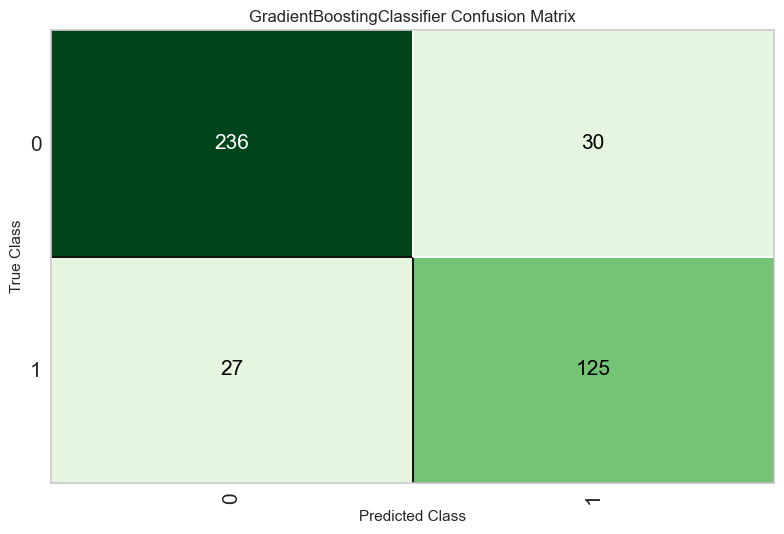

In [180]:
s.plot_model(best, plot = 'confusion_matrix')

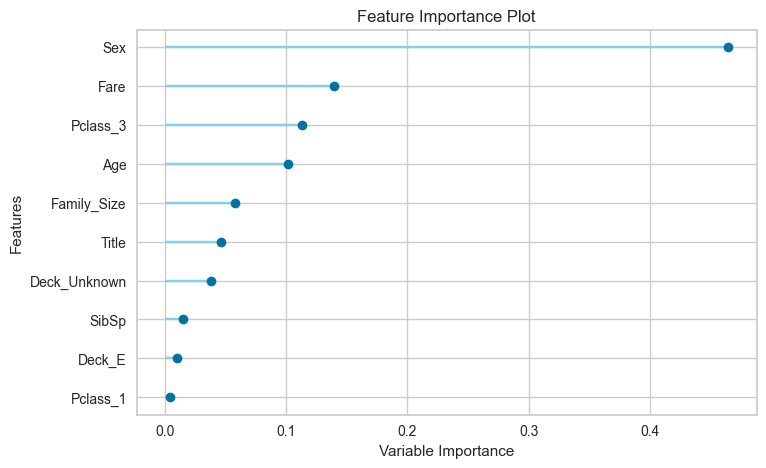

In [181]:
s.plot_model(best, plot = 'feature')

In [182]:
s.predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8636,0.9230,0.8224,0.8065,0.8143,0.7066,0.7067


,Sex,Age,SibSp,Parch,Fare,IsAlone,Embarked,Family_Size,Title,Pclass_1,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Num_Women_in_Family,Survived,prediction_label,prediction_score
891,1,3.57,0,0,2.18,1,0,1,3,0,...,0,0,0,0,0,1,0.00,0,0,0.89
892,0,3.87,1,0,2.08,0,0,2,4,0,...,0,0,0,0,0,1,0.00,1,1,0.51
893,1,4.14,0,0,2.37,1,0,1,3,0,...,0,0,0,0,0,1,0.00,0,0,0.69
894,1,3.33,0,0,2.27,1,0,1,3,0,...,0,0,0,0,0,1,0.00,0,0,0.80
895,0,3.14,1,1,2.59,0,0,3,4,0,...,0,0,0,0,0,1,0.00,1,1,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1,3.50,0,0,2.20,1,0,1,3,0,...,0,0,0,0,0,1,0.00,0,0,0.78
1305,0,3.69,0,0,4.70,1,0,1,0,1,...,0,0,0,0,0,0,0.00,1,1,0.97
1306,1,3.68,0,0,2.11,1,0,1,3,0,...,0,0,0,0,0,1,0.00,0,0,0.92
1307,1,3.50,0,0,2.20,1,0,1,3,0,...,0,0,0,0,0,1,0.00,0,0,0.78


In [183]:
results = s.predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8636,0.9230,0.8224,0.8065,0.8143,0.7066,0.7067


In [184]:
results[results['Survived'] != results['prediction_label']]

,Sex,Age,SibSp,Parch,Fare,IsAlone,Embarked,Family_Size,Title,Pclass_1,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Num_Women_in_Family,Survived,prediction_label,prediction_score
897,0,3.43,0,0,2.16,1,0,1,2,0,...,0,0,0,0,0,1,0.00,1,0,0.58
912,1,2.30,0,1,1.43,0,0,2,1,0,...,0,0,0,0,0,1,0.00,0,1,0.51
919,1,3.74,0,0,3.45,1,0,1,3,1,...,0,0,0,0,0,0,0.00,0,1,0.62
924,0,3.69,1,2,3.20,0,0,4,4,0,...,0,0,0,0,0,1,0.00,1,0,0.70
927,0,3.13,0,0,2.20,1,0,1,2,0,...,0,0,0,0,0,1,0.00,1,0,0.65
928,0,3.09,0,0,2.27,1,0,1,2,0,...,0,0,0,0,0,1,0.00,1,0,0.65
930,1,3.50,0,0,4.05,1,0,1,3,0,...,0,0,0,0,0,1,0.00,0,1,0.57
932,1,3.50,0,0,3.32,1,0,1,3,1,...,1,0,0,0,0,0,0.00,0,1,0.84
963,0,3.40,0,0,2.19,1,0,1,2,0,...,0,0,0,0,0,1,0.00,1,0,0.57
971,1,1.95,1,1,2.79,0,0,3,1,0,...,0,0,0,0,0,1,0.00,0,1,0.55
